Classic models of the primary visual cortex (V1) are built on the humble [gabor filter](https://en.wikipedia.org/wiki/Gabor_filter) (e.g., [Adelson & Bergen (1985)](https://doi.org/10.1364/JOSAA.2.000284); [Jones & Palmer, 1987](https://doi.org/10.1152/jn.1987.58.6.1233); [Kay et al., 2008](https://doi.org/10.1038/nature06713)). In this notebook I demonstrate how [a small toolbox I wrote](https://github.com/jooh/gwp) can be used to extract such Gabor feature maps for a given image.

The basic idea with the toolbox is to piggyback on Tensorflow's highly performant implementation of ND convolution. Ordinarily you'd use this to obtain predictions in the forward pass of a convolutional neural net, but we can just as well construct a Gabor filter representation instead. The difference is that we impose a fixed Gabor instead of learning the filter during training. We can then access Tensorflow's neat nonlinear minimisation techniques to fit other aspects of the model to neural data.

In this first part, we will review the basic Gabor filter energy model and how it encodes an example image.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
# TF maintainers need to update their Numpy
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import tensorflow as tf
import skimage.data
import gwp
plt.rc('image', cmap='gray')
tf.enable_eager_execution()

## Gabor filters
Let's first of all remind ourselves of what a Gabor filter looks like. At a high level, it's just a 2D sinusoid point-multiplied by a Gaussian aperture:

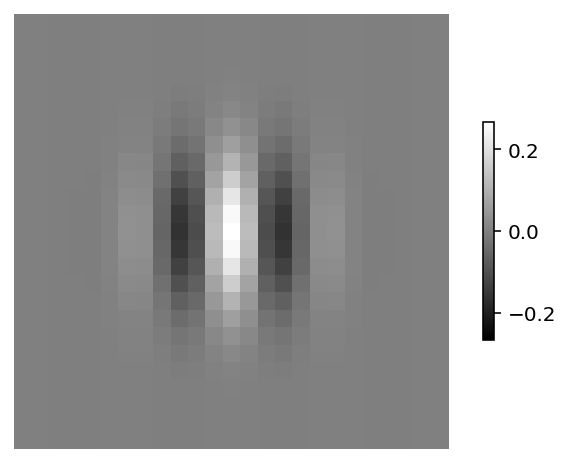

In [2]:
# the interesting parameters are
# The size of the Gaussian aperture in standard deviations
sigma = 3.
# The frequency of the sinusoidal modulation, which
# controls the spatial frequency tuning of the filter. 
# We can often yoke this to the aperture size to ensure
# we sample a full period of the sinusoid within a reasonably-
# open part of the Gaussian aperture
frequency = 0.5 / sigma
# notice that this is all quite interpretable:
# 1 / (0.5 / 3.) = 6 pixels, and if you count the black-to-black
# transition below, that's what it is
# the orientation of the sinusoid in radians
orientation = 0.
# the phase of the sinusoid (we often collapse this
# by calculating the complex cell-like energy instead, see below)
phase = 0.
# size of the overall matrix - just needs to be big enough
# to avoid cropping the edges of the Gaussian aperture. 4 is plenty
size_std = 4.

gabor = np.real(
                skimage.filters.gabor_kernel(
                    frequency=frequency,
                    theta=orientation,
                    sigma_x=sigma,
                    sigma_y=sigma,
                    offset=phase,
                    n_stds=size_std,
                )
            )
# important to set unit length if you want to compare responses
# across filters with different sizes
gabor /= np.linalg.norm(gabor)
absmax = np.max(np.abs(gabor))

fig, ax = plt.subplots(1, 1)
ax.set_axis_off()
im = ax.imshow(gabor, vmin=-absmax, vmax=absmax)
fig.colorbar(im, shrink=.5)
None

This filter has many useful properties:
* The filter is mean-zero, so an edge that fills the receptive field (the part where the filter is non-zero) will elicit no response, and a sufficiently sharp edge will also elicit little response. The filter is *band-pass* for a particular spatial frequency range
* Similarly, a bar or grating that is oriented orthogonally to the preferred orientation will elicit no response, since all the modulations will cancel out exactly over the filter. The filter is orientation-selective
* The overall position of the filter can be varied relative to the image to characterise [retinotopy](https://en.wikipedia.org/wiki/Retinotopy). In practice, we use convolutional operations to conveniently measure the response of a set of filters to lots of image positions
* (The filter is also tuned to a particular *phase*, but as we'll see below we often collapse over this dimension in practice)

So overall, we obtain a filter that is tuned to edges at a particular *spatial frequency*, a particular *orientation*, and a particular *location*. Not coincidentally, these are the fundamental dimensions over which cells in the primary visual cortex are known to be tuned.

## Gabor filter banks and V1 energy
To make this more concrete, let's see how a bank of Gabor filters encode an example image:

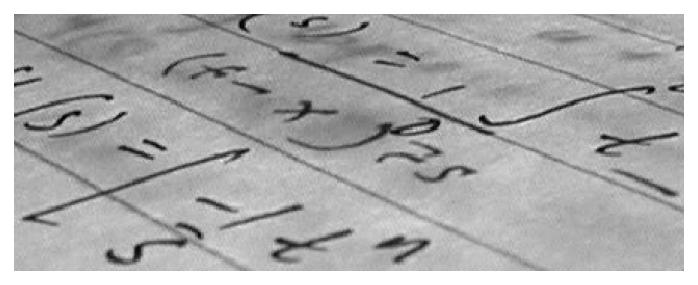

In [3]:
image = skimage.data.text().astype(float)
image /= image.max()
fig, ax = plt.subplots(1, 1)
ax.imshow(image)
ax.set_axis_off()
# reshape array to match convention (index by height by width by channel)
image = image[None, :, :, None]
dc = image.mean()
# zero mean to avoid picking up on edge effects
image -= dc

Now we extend our Gabor representation slightly by constructing a standard [Adelson & Bergen (1985)](https://doi.org/10.1364/JOSAA.2.000284) energy model. The model is going to be a set of Gabor filters which vary in orientation (8 is plenty), and phase (2 at quadrature offset, which will turn out to be useful). The filters are then convolved with the image at some stride to obtain one filter response for each sampled location in the image.

In [4]:
# configure gabor model
orientations = gwp.n2orientations(8)
# quadrature-offset filters
bank = [gwp.gaborbank(sigma=sigma, orientations=orientations, nsigma=4, phase=thisphase)
                for thisphase in [0, np.pi/2]]
bank[0].shape

(25, 25, 1, 8)

Each phase value appears as its own list entry, and contains an array of [vertical, horizontal, 1, orientation] The key V1 energy operation is to calculate the square root over the summed and squared phase maps. Why is that useful? Well, it produces a *phase-invariant* edge detector - by using just two phase values we can be sensitive to an edge that falls *anywhere* within the Gaussian window of the filter. The response will vary with the edge's position relative to the Gaussian window, but the phase of the edge will no longer matter. This operation also serves to rectify the output of the model - the typical data for these models comes from neuronal firing rates, which do not take negative values.

The interpretation of this operation in Adelson & Bergen (1985) and similar V1 physiology papers is in terms of the computation of V1 simple and complex cells. Complex cells are known to be phase-invariant, and the idea here is that they achieve this by summing over the responses of phase-sensitive simple cells (the individual Gabors). Let's make this more concrete by visualising one of the orientation filters again.

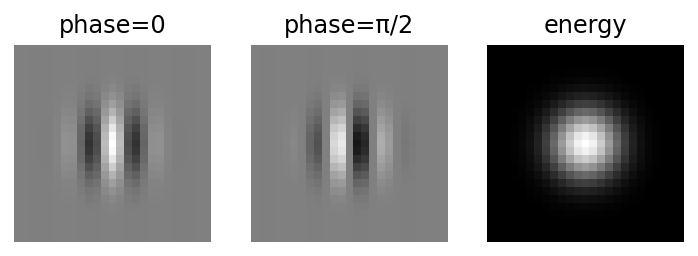

In [5]:
energy = gwp.v1energy(*bank)
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
[this_ax.set_axis_off() for this_ax in ax.ravel()]
bankmax = max(*[np.abs(thisbank).max() for thisbank in bank])
ax[0].imshow(bank[0][:,:,0,0], vmin=-bankmax, vmax=bankmax)
ax[0].set_title('phase=0')
ax[1].imshow(bank[1][:,:,0,0], vmin=-bankmax, vmax=bankmax)
ax[1].set_title('phase=π/2')
ax[2].imshow(energy[:,:,0,0])
ax[2].set_title('energy')
None

As you can see, the energy representation of the two quadrature-phase filters becomes a Gaussian.

(The mathsy among you may also be aware that we could construct the quadrature-offset filter pairs by taking the real and the imaginary parts of the same Gabor kernel - but Tensorflow doesn't like imaginary numbers so we'll avoid this route!)

Let's explore how the energy output looks for each orientation by plotting out the response at each filter location.

In [6]:
# convolve banks with stimulus to obtain raw responses
stride = 2 * sigma
responses = [gwp.convolver(image, thisphasebank, stride) for thisphasebank in bank]
# calculate V1 energy (sum of squares)
energy = gwp.v1energy(*responses)

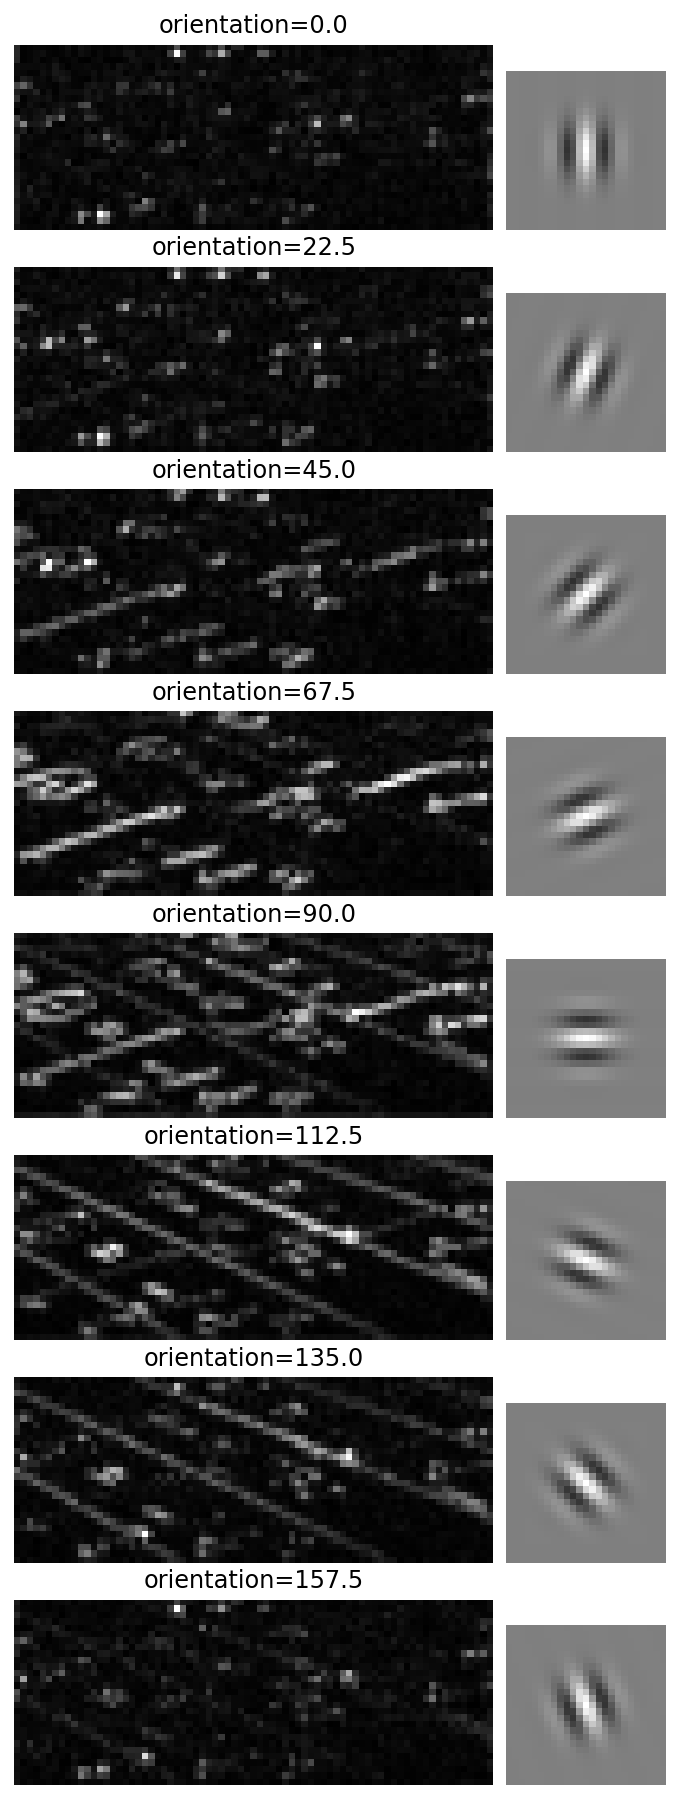

In [7]:
fig,ax = plt.subplots(len(orientations), 1, figsize=[5, 16])

# you could verify pixel size voodoo below with something like this
data2pix = lambda this_ax: np.abs(np.diff(this_ax.transData.transform([(0,0),(1,1)]), axis=0))

#[this_ax.set_axis_off() for this_ax in ax.ravel()]
bank_ax = []
n_col = 1
for ind, energy_ax in enumerate(ax):
    energy_ax.imshow(energy[0,:,:,ind], vmin=0.)
    energy_ax.set_title(f"orientation={orientations[ind] * (180./np.pi)}")
    # (3 days of my life coming up in the next few lines...)
    # let's have the filter with the same pixel size!
    # pixel (width, height) of energy_ax in *normalised figure units*
    pixel_size_energy = np.abs(
        np.diff(
            fig.transFigure.inverted().transform(
                energy_ax.transData.transform([(0,0),(1,1)])
            ), axis=0
        )
    ).flatten()
    # implies that bank_ax needs to have this (width, height)
    bank_size = (bank[0].shape[1] * pixel_size_energy[0], bank[0].shape[0] * pixel_size_energy[1])
    # place the new axis
    energy_ax_pos = energy_ax.get_position(original=False)
    # hack a multi-column representation since filters are often larger than response map
    bank_ax_pos = [energy_ax_pos.x1 + (bank_size[0] * np.remainder(ind, n_col)),
                                       energy_ax_pos.y0, bank_size[0], bank_size[1]]
    bank_ax.append(fig.add_axes(bank_ax_pos))
    bank_ax[-1].imshow(bank[0][:,:,0,ind], vmin=-bankmax, vmax=bankmax)
[this_ax.set_axis_off() for this_ax in ax]
[this_ax.set_axis_off() for this_ax in bank_ax]
None

When viewed together with the corresponding filter, these maps are kind of intuitive. The orientations that coincide with the supporting lines and the major symbols in the image generate high energy values.

We can construct a local contrast map by summing over these orientation filters.

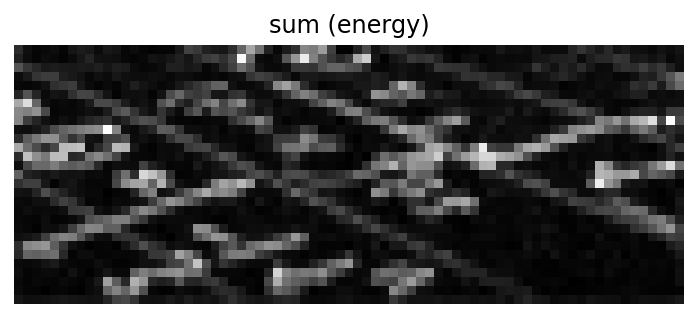

In [8]:
# or just summing the orientation channels (that is, equal weight on all orientations)
fig, ax = plt.subplots(1, 1)
ax.imshow(np.sum(energy[0,:,:,:], axis=2))
ax.set_title('sum (energy)')
ax.set_axis_off()

This is a map of local contrast in the image at a particular spatial frequency band.

Notice that it doesn't actually matter whether the local contrast relations are light-to-dark or the other way around. So for instance, we can take the complement of the image, and check its energy representation:

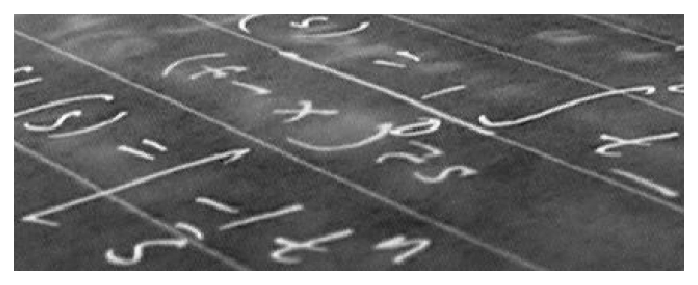

In [9]:
# reverse all local contrast relations
image_invert = image * -1
fig, ax = plt.subplots(1, 1)
ax.imshow(dc + image_invert[0,:,:,0])
ax.set_axis_off()

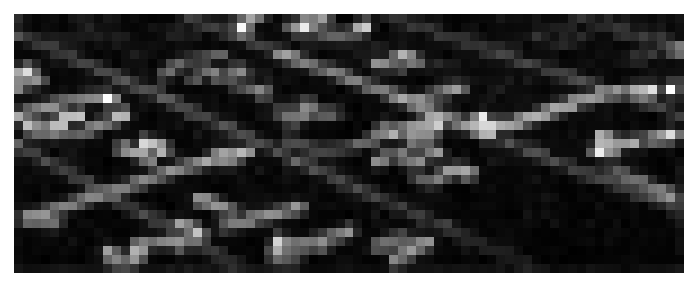

In [10]:
energy_invert = gwp.v1energy(*[gwp.convolver(image_invert, thisphasebank, stride) for thisphasebank in bank])
fig, ax = plt.subplots(1, 1)
ax.imshow(np.sum(energy_invert[0,:,:,:], axis=2))
ax.set_axis_off()

Hey look, it's the same response we got to the original image:

In [11]:
np.allclose(energy, energy_invert)

True

So this Gabor model is sensitive to the position, orientation, and spatial frequency of edges in the image, but it doesn't matter if the edges are light-on-dark or the other way around. This is generally what you want if you're thinking about a process like figure-ground segregation (although you can imagine interesting counter-examples, for instance [classic face detection algorithms](https://en.wikipedia.org/wiki/Viola%E2%80%93Jones_object_detection_framework) depend on the *sign* of particular local contrast relations in the image).

# Spatial frequency banks
The *pyramid* part in GWP comes from the typical arrangement of the model into multiple banks, where each bank features larger filters (sigma) and a greater stride. The change in stride results in a pyramid arrangement of arrays - the top of the pyramid is a small number of very large filters, and the bottom a large number of small filters. Each level of the pyramid then encodes a particular spatial frequency band in an efficient manner by using fewer filters to encode coarser, low-spatial frequency content.

In [12]:
# so to extend our model, we can add further filters like so
pyramid = {}
sigma_values = np.arange(2., 9.)
frequencies = {this_sigma: (0.5 / this_sigma) * image.shape[2] for this_sigma in sigma_values}

for this_sigma, this_frequency in frequencies.items():
    pyramid[this_frequency] = [gwp.gaborbank(sigma=this_sigma, orientations=orientations, nsigma=4, phase=thisphase)
                for thisphase in [0, np.pi/2]]

In [13]:
# energy at each level of the pyramid
def model_response(pyramid, image):
    pyramid_energy_map = {}
    pyramid_energy_orient = {}
    for this_frequency, this_bank in pyramid.items():
        # for ease of comparison, we set stride=1 here so that each feature map has the same shape
        # (so not actually a pyramid but an apartment building)
        responses = [gwp.convolver(image, thisphasebank, 1) for thisphasebank in this_bank]
        energy = gwp.v1energy(*responses)
        pyramid_energy_map[this_frequency] = np.sum(energy[0,:,:,:], axis=2)
        pyramid_energy_orient[this_frequency] = np.mean(energy[0,:,:,:], axis=(0,1))
    return pyramid_energy_map, pyramid_energy_orient

pyramid_energy_map, pyramid_energy_orient = model_response(pyramid, image)

So let's visualise what the responses look like across the banks:

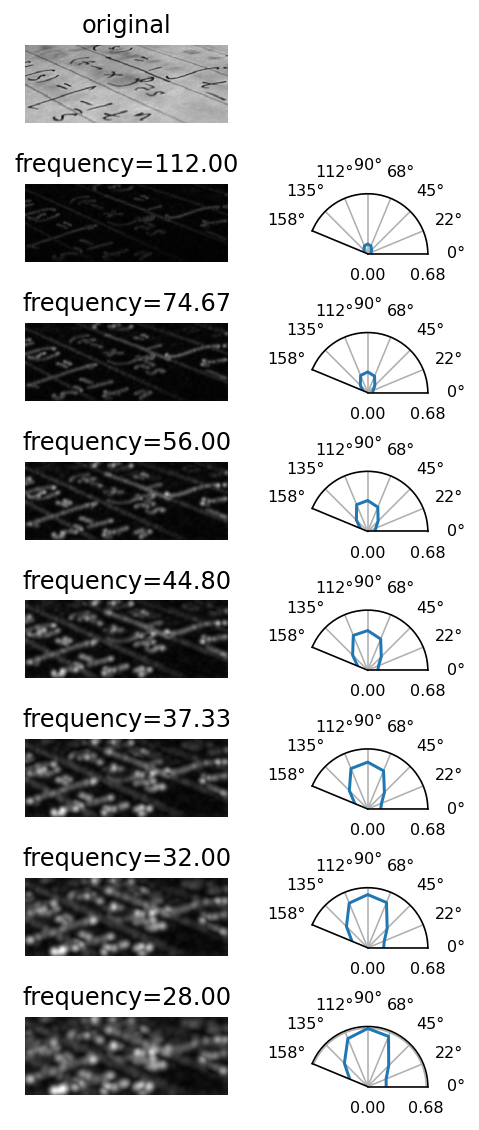

In [14]:
# visualise model responses
def response_visualise(pyramid_energy_map, pyramid_energy_orient, image):
    fig = plt.figure(figsize=(4,10))
    absmax = max([np.max(this_energy) for this_energy in pyramid_energy_map.values()])
    orimax = max([np.max(this_energy) for this_energy in pyramid_energy_orient.values()])
    im_ax = []
    n_p = 2
    for this_frequency in pyramid_energy_map.keys():
        im_ax.append(fig.add_subplot(len(pyramid)+1, 2, n_p+1))
        im_ax[-1].imshow(pyramid_energy_map[this_frequency], vmin=0, vmax=absmax)
        im_ax[-1].set_title(f"frequency={this_frequency:.2f}", rotation=0)
        ori_ax = fig.add_subplot(len(pyramid)+1, 2, n_p+2, projection='polar')
        ori_ax.plot(orientations, pyramid_energy_orient[this_frequency])
        ori_ax.set_thetamin(np.min(orientations))
        ori_ax.set_thetamax(np.max(orientations))
        ori_ax.set_xticks(orientations)
        ori_ax.set_rgrids([0, np.round(orimax,2)])
        ori_ax.tick_params(axis='both', which='major', labelsize=8)
        n_p += 2
    im_ax.append(fig.add_subplot(len(pyramid)+1, 2, 1))
    im_ax[-1].imshow(dc + image[0,:,:,0])
    im_ax[-1].set_title('original')
    [this_ax.set_axis_off() for this_ax in im_ax]
    return

response_visualise(pyramid_energy_map, pyramid_energy_orient, image)

The left columns shows the spatial map we plotted previously, and the right column shows the mean energy across space for each orientation filter. We can see that the dominant orientation is at about 90 degrees. Also, edge energy appears to increase as the spatial frequency of the filter (in cycles per image width) decreases.

We might worry about artefacts at this point, so let's reassure ourselves that a white noise image does not show these effects:

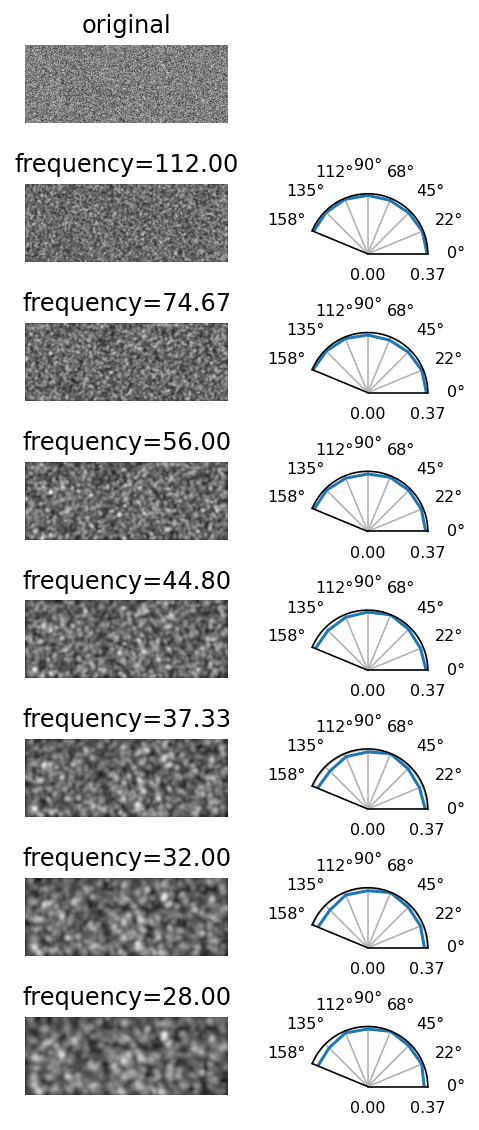

In [15]:
noise_image = np.random.rand(*image.shape) - .5
noise_pyramid_energy_map, noise_pyramid_energy_orient = model_response(pyramid, noise_image)
response_visualise(noise_pyramid_energy_map, noise_pyramid_energy_orient, noise_image)

Well, I'm reassured - the edge energy appears similar across spatial scales and across orientations for a noise image, so there isn't a trivial explanation for the natural image result.

Let's collapse the orientation channel as well to obtain a single mean edge energy value per spatial scale:

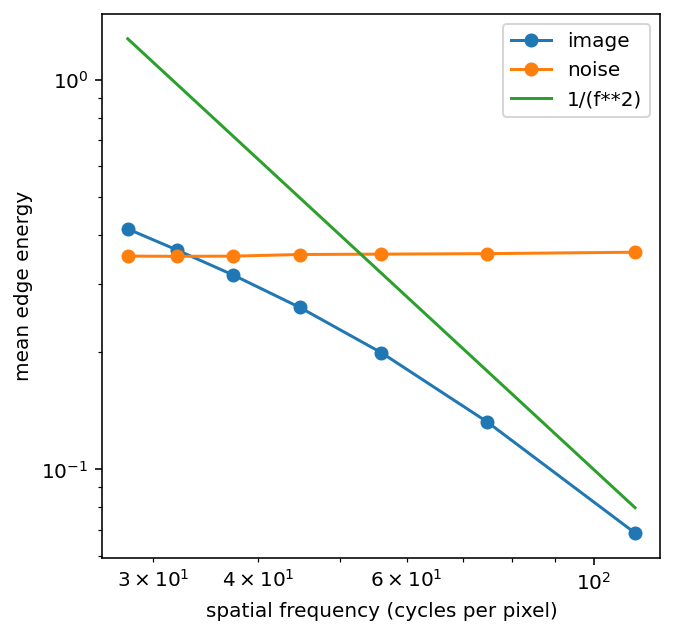

In [16]:
fig,ax = plt.subplots(1, 1, figsize=(5,5))
# ha ha
ax.plot(*zip(*[(this_key, this_ori.mean()) for (this_key, this_ori) in pyramid_energy_orient.items()]), 'o-', label='image')
ax.plot(*zip(*[(this_key, this_ori.mean()) for (this_key, this_ori) in noise_pyramid_energy_orient.items()]), 'o-', label='noise')
f2 = {this_key: 1000*(1/(this_key**2)) for this_key in frequencies.values()}
ax.plot(*zip(*f2.items()), label='1/(f**2)')
ax.set_ylabel('mean edge energy')
ax.set_xlabel('spatial frequency (cycles per pixel)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
None

The noise image has a flat spectrum, as your might expect for unstructured noise. But in this log-log plot the natural image spectrum falls off in an almost linear fashion. This is a classic observation in natural image analysis. The amplitude spectrum for most natural images exhibits this $1/f^2$ type relationship (e.g., [Burton & Moorhead, 1987](https://doi.org/10.1364/AO.26.000157); [Tolhurst et al., 1992](https://doi.org/10.1111/j.1475-1313.1992.tb00296.x); [Field, 1987](https://doi.org/10.1364/JOSAA.4.002379)).

(The observant of you will notice a fudge factor of 1000 to get the 1/f line on the same scale as the filter outputs. I'm not quite sure why this was necessary here.)

## Conclusion
That's all for today. It's fun using a state-of-the-art machine learning library to build something as old-fashioned as a gabor-filter model. Hopefully you can see the point of this exercise: Gabor filters are not just a reasonable starting point for modelling V1 (it's often said that you can account for about 50% of the variance in responsive V1 cells this way, although the original reference eludes me), they are also amazingly interpretable compared to more contemporary visual neuroscience models (*cough*CNNs*cough*). We will cover how to actually fit the model to data in the next instalment, but perhaps you can already see that once you have parameter estimates for this kind of model it becomes *really* easy to characterise neural coding in terms of its fundamental dimensions - position, spatial frequency, orientation.